Load dependencies

In [1]:
using Revise
using StableDQMC
using BenchmarkTools
using LinearAlgebra
using Statistics
using Test
using GenericSVD
using JacobiSVD
using Plots
using StatsPlots
using LaTeXStrings
using DataStructures
using DataFrames
using Quadmath
using HDF5
using BSON: @save, @load

┌ Info: Precompiling StableDQMC [0827807b-44c9-51d0-af97-efe667fe6b2a]
└ @ Base loading.jl:1260


Configure plotting defaults

In [2]:
pyplot();
PyPlot.plt.style.use(joinpath(pwd(),"../publication_tex.mplstyle"))
# single figure
default(
    framestyle = :grid,
    grid = true,
    legend = true,
    size = (1.6*360, 360),
    guidefont=font(14),
    xtickfont=font(12), 
    ytickfont=font(12), 
    legendfont=font(11),
    linewidth = 1.5
);

# styling for two figures displayed side by side
two_figures = (
    size = (1.6*360, 360),
    guidefont=font(21),
    xtickfont=font(18),  # was 16
    ytickfont=font(18), 
    legendfont=font(18),
);
two_figures_squarish = (
    size = (1.3*360, 360),
    guidefont=font(18),
    xtickfont=font(18),  # was 16
    ytickfont=font(18), 
    legendfont=font(16),
);

Basic tests

In [3]:
# Multiple Bs, i.e. B_M, B_M-1, ... B_1
@testset "Basic tests" begin
    Bs = [rand(400,400) for _ in 1:3] # regular matrix
    result = reduce(*,reverse(Bs))
    @test isapprox(Matrix(calc_Bchain_svd(Bs; svdalg = gesdd)[1]), result)
    @test isapprox(Matrix(calc_Bchain_svd(Bs; svdalg =  gesvd)[1]), result)
    @test isapprox(Matrix(calc_Bchain_svd(Bs; svdalg =  genericsvd)[1]), result)
    @test isapprox(Matrix(calc_Bchain_svd_faster(Bs; svdalg = gesvd)[1]), result)
    @test isapprox(Matrix(calc_Bchain_qr(Bs)[1]), result)
end;

Test Summary: | Pass  Total
Basic tests   |    5      5


In [39]:
@time calc_Bchain_svd_faster(x; svdalg = gesvd!);

  1.513635 seconds (133 allocations: 31.444 MiB)


In [40]:
@time calc_Bchain_svd_faster(x; svdalg = gesvd);

  1.499537 seconds (153 allocations: 43.651 MiB)


In [41]:
@time calc_Bchain_svd(x; svdalg = gesvd);

  1.519446 seconds (195 allocations: 71.726 MiB)


# SDW model data

In [4]:
sdwdata = Dict() # sdwdata[beta][i] where 1<=i<=M

h5open("scipost_sdw.h5", "r") do f
    for n in names(f)
        beta = parse(Int, split(n, "_")[2])
        M = Int(beta/0.1)
        d = Vector{Matrix{ComplexF64}}(undef, M)
        for i in 1:M
            d[i] = read(f[string(n,"/$i")])
        end
        sdwdata[beta] = d
    end
end

betas = keys(sdwdata) |> collect |> sort

1-element Array{Any,1}:
 40

# Slice matrix product chain

## Compute slice matrix product chain using different stabilizations

In [5]:
Bs = sdwdata[40]
M = length(Bs)
svs_qr_udt = calc_Bchain_qr(Bs)[2];
svs_gesvd  = calc_Bchain_svd(Bs; svdalg = gesvd)[2];
svs_gesdd  = calc_Bchain_svd(Bs; svdalg = gesdd)[2];
svs_gesvj  = calc_Bchain_svd(Bs; svdalg = gesvj)[2];

In [199]:
Bsbig_real = (x->BigFloat.(x)).(real(Bs))
Bsbig_imag = (x->BigFloat.(x)).(imag(Bs))
Bsbig = Bsbig_real + Bsbig_imag
@time setprecision(1000) do
    global svs_genericsvd = calc_Bchain_svd(Bsbig; svdalg = genericsvd)[2];
end;

570.471008 seconds (5.14 G allocations: 496.925 GiB, 12.18% gc time)


In [ ]:
Bsbig_real = (x->BigFloat.(x)).(real(Bs))
Bsbig_imag = (x->BigFloat.(x)).(imag(Bs))
Bsbig = Bsbig_real + Bsbig_imag
@time setprecision(1000) do
    global svs_genericsvd = calc_Bchain_svd_faster(Bsbig; svdalg = genericsvd!)[2];
end;

In [193]:
# svs_genericsvd_L4 = copy(svs_genericsvd)

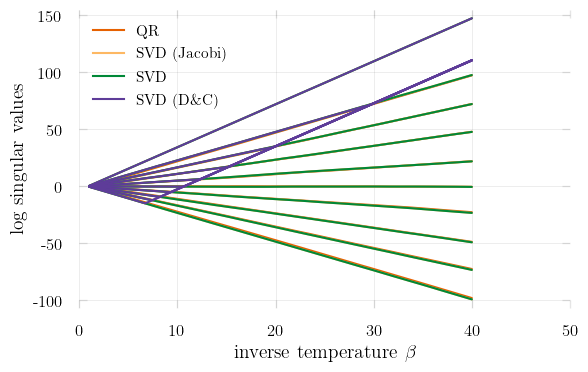

In [6]:
betas = range(1, M * 0.1, length=M)
# plot(betas, svs_genericsvd, color="#CA0020", labels = reshape(vcat(["exact"], fill("", 63)), (1,64)))
plot(betas, svs_qr_udt[:,1:40:end][:,2:end], color="#E66101", labels = reshape(vcat(["QR"], fill("", size(Bs[1],1)-1)), (1,size(Bs[1],1))))
plot!(betas, svs_gesvj[:,1:40:end], color="#FDB863", labels = reshape(vcat(["SVD (Jacobi)"], fill("", size(Bs[1],1)-1)), (1,size(Bs[1],1))))
plot!(betas, svs_gesvd[:,1:40:end], color="#008837", labels = reshape(vcat(["SVD"], fill("", size(Bs[1],1)-1)), (1,size(Bs[1],1))))
plot!(betas, svs_gesdd[:,1:40:end], color="#5E3C99", labels = reshape(vcat(["SVD (D\\&C)"], fill("", size(Bs[1],1)-1)), (1,size(Bs[1],1))))

ylabel!("log singular values")
xlabel!(L"inverse temperature $\beta$")
# ylims!(-160, 100)
xlims!(0., 50.)
# savefig("../../paper/figures_sdw/decomp_comparison_simple_SC_near_qcp.pdf")

In [7]:
cond(exp.(svs_qr_udt[end,:]))

2.102614040980458e126

# Accuracy: Equal-times Green's function

In [46]:
function accuracy_greens(Bs; svdinversion = inv_one_plus)
    Bsbig_real = (x->BigFloat.(x)).(real(Bs))
    Bsbig_imag = (x->BigFloat.(x)).(imag(Bs))
    Bsbig = Bsbig_real + Bsbig_imag
    
    Δs_qr    = SortedDict{Int, Float64}()
    Δs_gesvd = SortedDict{Int, Float64}()
    Δs_gesdd = SortedDict{Int, Float64}()
    Δs_gesvj = SortedDict{Int, Float64}()
    
    local G_genericsvd
    setprecision(1000) do
        F_genericsvd = calc_Bchain_svd_faster(Bsbig; svdalg = genericsvd!)[1];
        G_genericsvd = inv(I + Matrix(F_genericsvd))
    end
    
    for beta in (40) #range(5, 40, step=5)         
        # Bchain
        F_qr_udt = calc_Bchain_qr(Bs)[1];
        F_gesvd  = calc_Bchain_svd_faster(Bs; svdalg = gesvd)[1];
        F_gesdd  = calc_Bchain_svd_faster(Bs; svdalg = gesdd)[1];
        F_gesvj  = calc_Bchain_svd_faster(Bs; svdalg = StableDQMC.gesvj)[1];
        
        # inversion
        G_qr_udt = inv_one_plus(F_qr_udt)
        G_gesvd  = svdinversion(F_gesvd; svdalg = gesvd!)
        G_gesdd  = svdinversion(F_gesdd; svdalg = gesdd!)
        G_gesvj  = svdinversion(F_gesvj; svdalg = StableDQMC.gesvj!)
        
        Δs_qr[beta]    = maximum(abs.(G_qr_udt - G_genericsvd))
        Δs_gesvd[beta] = maximum(abs.(G_gesvd - G_genericsvd))
        Δs_gesdd[beta] = maximum(abs.(G_gesdd - G_genericsvd))
        Δs_gesvj[beta] = maximum(abs.(G_gesvj - G_genericsvd))
    end
    

    return Δs_qr, Δs_gesvd, Δs_gesdd, Δs_gesvj
end

accuracy_greens (generic function with 1 method)

## Regular inversion

In [47]:
Bs = sdwdata[40]
@time Δs_qr, Δs_gesvd, Δs_gesdd, Δs_gesvj = accuracy_greens(Bs);

InterruptException: InterruptException:

In [220]:
@save "accuracy_greens_svd_regularinv_near_qcp.bson" Δs_qr Δs_gesvd Δs_gesdd Δs_gesvj

In [221]:
@load "accuracy_greens_svd_regularinv_near_qcp.bson" Δs_qr Δs_gesvd Δs_gesdd Δs_gesvj

In [239]:
betas = collect(keys(Δs_qr))
p = plot(betas, log.(10, values(Δs_qr)), color="#E66101", marker=true, label="QR", legend=true; two_figures_squarish...)
plot!(betas, log.(10, values(Δs_gesvd)), color="#008837", marker=true, label="SVD")
# plot!(betas, log.(10, values(Δs_gesdd)), color="#5E3C99", marker=true, label="SVD (D\\&C)")
plot!(betas, log.(10, values(Δs_gesvj)), color="#FDB863", marker=true, label="SVD (Jacobi)")


xlabel!(L"inverse temperature $\beta$")
ylabel!(L"\Delta G")
# ylims!(0., 1e-3)
savefig("../../paper/figures_sdw/accuracy_greens_svd_regularinv_near_qcp.pdf")

PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= /Users/crstnbr/.julia/packages/PyCall/zqDXB/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'RuntimeError'>
RuntimeError("latex was not able to process the following string:\nb'-3.780295\\\\xd710\\\\u207b\\\\xb9'\n\nHere is the full report generated by latex:\nThis is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019) (preloaded format=latex)\n restricted \\write18 enabled.\nentering extended mode\n(/Users/crstnbr/.matplotlib/tex.cache/54eadf82e3069588ff1c4a3de3d1b6e0.tex\nLaTeX2e <2018-12-01>\n(/usr/local/texlive/2019/texmf-dist/tex/latex/base/article.cls\nDocument Class: article 2018/09/03 v1.4i Standard LaTeX document class\n(/usr/local/texlive/2019/texmf-dist/tex/latex/base/size10.clo))\n(/usr/local/texlive/2019/texmf-dist/tex/latex/type1cm/type1cm.sty)\n(/usr/local/texlive/2019/texmf-dist/tex/latex/base/textcomp.sty\n(/usr/local/texlive/2019/texmf-dist/tex/latex/base/ts1enc.def\n(/usr/local/texlive/2019/texmf-dist/tex/latex/base/ts1enc.dfu)))\n(/usr/local/texlive/2019/texmf-dist/tex/latex/base/inputenc.sty)\n(/usr/local/texlive/2019/texmf-dist/tex/latex/geometry/geometry.sty\n(/usr/local/texlive/2019/texmf-dist/tex/latex/graphics/keyval.sty)\n(/usr/local/texlive/2019/texmf-dist/tex/generic/oberdiek/ifpdf.sty)\n(/usr/local/texlive/2019/texmf-dist/tex/generic/oberdiek/ifvtex.sty)\n(/usr/local/texlive/2019/texmf-dist/tex/generic/ifxetex/ifxetex.sty)\n\nPackage geometry Warning: Over-specification in `h'-direction.\n    `width' (5058.9pt) is ignored.\n\n\nPackage geometry Warning: Over-specification in `v'-direction.\n    `height' (5058.9pt) is ignored.\n\n) (./54eadf82e3069588ff1c4a3de3d1b6e0.aux)\n(/usr/local/texlive/2019/texmf-dist/tex/latex/base/ts1cmr.fd)\n*geometry* driver: auto-detecting\n*geometry* detected driver: dvips\n\nLaTeX Font Warning: Font shape `TS1/cmr/m/n' in size <18> not available\n(Font)              size <17.28> substituted on input line 14.\n\n\n! Package inputenc Error: Unicode character ⁻ (U+207B)\n(inputenc)                not set up for use with LaTeX.\n\nSee the inputenc package documentation for explanation.\nType  H <return>  for immediate help.\n ...                                              \n                                                  \nl.14 ...000}{22.500000}{\\rmfamily -3.780295×10⁻\n                                                  ¹}\nNo pages of output.\nTranscript written on 54eadf82e3069588ff1c4a3de3d1b6e0.log.\n\n\n")
  File "/Users/crstnbr/opt/anaconda3/lib/python3.7/site-packages/matplotlib/artist.py", line 38, in draw_wrapper
    return draw(artist, renderer, *args, **kwargs)
  File "/Users/crstnbr/opt/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py", line 1709, in draw
    renderer, self, artists, self.suppressComposite)
  File "/Users/crstnbr/opt/anaconda3/lib/python3.7/site-packages/matplotlib/image.py", line 135, in _draw_list_compositing_images
    a.draw(renderer)
  File "/Users/crstnbr/opt/anaconda3/lib/python3.7/site-packages/matplotlib/artist.py", line 38, in draw_wrapper
    return draw(artist, renderer, *args, **kwargs)
  File "/Users/crstnbr/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py", line 2647, in draw
    mimage._draw_list_compositing_images(renderer, self, artists)
  File "/Users/crstnbr/opt/anaconda3/lib/python3.7/site-packages/matplotlib/image.py", line 135, in _draw_list_compositing_images
    a.draw(renderer)
  File "/Users/crstnbr/opt/anaconda3/lib/python3.7/site-packages/matplotlib/artist.py", line 38, in draw_wrapper
    return draw(artist, renderer, *args, **kwargs)
  File "/Users/crstnbr/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axis.py", line 1205, in draw
    renderer)
  File "/Users/crstnbr/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axis.py", line 1150, in _get_tick_bboxes
    for tick in ticks if tick.label1.get_visible()],
  File "/Users/crstnbr/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axis.py", line 1150, in <listcomp>
    for tick in ticks if tick.label1.get_visible()],
  File "/Users/crstnbr/opt/anaconda3/lib/python3.7/site-packages/matplotlib/text.py", line 890, in get_window_extent
    bbox, info, descent = self._get_layout(self._renderer)
  File "/Users/crstnbr/opt/anaconda3/lib/python3.7/site-packages/matplotlib/text.py", line 298, in _get_layout
    clean_line, self._fontproperties, ismath=ismath)
  File "/Users/crstnbr/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py", line 201, in get_text_width_height_descent
    s, fontsize, renderer=self)
  File "/Users/crstnbr/opt/anaconda3/lib/python3.7/site-packages/matplotlib/texmanager.py", line 448, in get_text_width_height_descent
    dvifile = self.make_dvi(tex, fontsize)
  File "/Users/crstnbr/opt/anaconda3/lib/python3.7/site-packages/matplotlib/texmanager.py", line 338, in make_dvi
    texfile], tex)
  File "/Users/crstnbr/opt/anaconda3/lib/python3.7/site-packages/matplotlib/texmanager.py", line 317, in _run_checked_subprocess
    exc=exc.output.decode('utf-8'))) from exc


## Loh et al inversion

In [33]:
@time Δs_qr, Δs_gesvd, Δs_gesdd, Δs_gesvj = accuracy_greens(B0, svdinversion = inv_one_plus_loh);

 18.314995 seconds (80.23 M allocations: 6.622 GiB, 5.77% gc time)


In [34]:
@time Δs_qr1, Δs_gesvd1, Δs_gesdd1, Δs_gesvj1 = accuracy_greens(B1, svdinversion = inv_one_plus_loh);

 18.630647 seconds (80.57 M allocations: 6.800 GiB, 5.36% gc time)


In [35]:
@save "accuracy_greens_svd_loh.bson" Δs_qr Δs_gesvd Δs_gesdd Δs_gesvj Δs_qr1 Δs_gesvd1 Δs_gesdd1 Δs_gesvj1

In [16]:
@load "accuracy_greens_svd_loh.bson" Δs_qr Δs_gesvd Δs_gesdd Δs_gesvj Δs_qr1 Δs_gesvd1 Δs_gesdd1 Δs_gesvj1

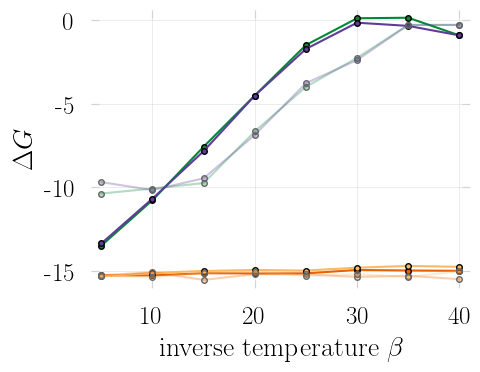

In [17]:
betas = collect(keys(Δs_qr))
p = plot(betas, log.(10, values(Δs_qr)), color="#E66101", marker=true, label="QR", legend=false; two_figures_squarish...)
plot!(betas, log.(10, values(Δs_gesvd)), color="#008837", marker=true, label="SVD")
plot!(betas, log.(10, values(Δs_gesdd)), color="#5E3C99", marker=true, label="SVD (D\\&C)")
plot!(betas, log.(10, values(Δs_gesvj)), color="#FDB863", marker=true, label="SVD (Jacobi)")

plot!(betas, log.(10, values(Δs_qr1)), color="#E66101", alpha=.3, msc="#666666", marker=true, label="")
plot!(betas, log.(10, values(Δs_gesvd1)), color="#008837", alpha=.3, msc="#666666", marker=true, label="")
plot!(betas, log.(10, values(Δs_gesdd1)), color="#5E3C99", alpha=.3, msc="#666666", marker=true, label="")
plot!(betas, log.(10, values(Δs_gesvj1)), color="#FDB863", alpha=.3, msc="#666666", marker=true, label="")

xlabel!(L"inverse temperature $\beta$")
ylabel!(L"\Delta G")
savefig("../paper/figures/accuracy_greens_svd_loh.pdf")

## Loh et al inversion

In [46]:
@time Δs_abs_qr, Δs_abs_gesvd, Δs_abs_gesdd, Δs_abs_gesvj,
Δs_rel_qr, Δs_rel_gesvd, Δs_rel_gesdd, Δs_rel_gesvj = accuracy_determinant(B0, svdinversion = svd_inv_one_plus_loh)

@time Δs_abs_qr1, Δs_abs_gesvd1, Δs_abs_gesdd1, Δs_abs_gesvj1,
Δs_rel_qr1, Δs_rel_gesvd1, Δs_rel_gesdd1, Δs_rel_gesvj1 = accuracy_determinant(B1, svdinversion = svd_inv_one_plus_loh);

 16.203550 seconds (76.14 M allocations: 6.450 GiB, 4.16% gc time)
 17.743752 seconds (80.93 M allocations: 6.830 GiB, 3.90% gc time)


In [47]:
@save "accuracy_det_svd_loh.bson" Δs_abs_qr Δs_abs_gesvd Δs_abs_gesdd Δs_abs_gesvj Δs_rel_qr Δs_rel_gesvd Δs_rel_gesdd Δs_rel_gesvj Δs_abs_qr1 Δs_abs_gesvd1 Δs_abs_gesdd1 Δs_abs_gesvj1 Δs_rel_qr1 Δs_rel_gesvd1 Δs_rel_gesdd1 Δs_rel_gesvj1

In [244]:
@load "accuracy_det_svd_loh.bson" Δs_abs_qr Δs_abs_gesvd Δs_abs_gesdd Δs_abs_gesvj Δs_rel_qr Δs_rel_gesvd Δs_rel_gesdd Δs_rel_gesvj Δs_abs_qr1 Δs_abs_gesvd1 Δs_abs_gesdd1 Δs_abs_gesvj1 Δs_rel_qr1 Δs_rel_gesvd1 Δs_rel_gesdd1 Δs_rel_gesvj1

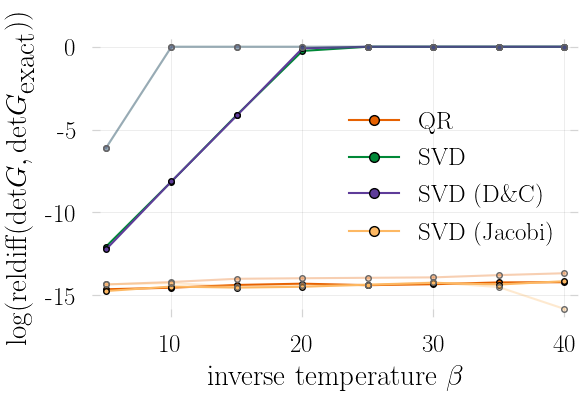

In [245]:
betas = collect(keys(Δs_rel_qr))

p = plot(betas, log.(10, values(Δs_rel_qr)), color="#E66101", marker=true, label="QR", legend=:right; two_figures...)
plot!(betas, log.(10, values(Δs_rel_gesvd)), color="#008837", marker=true, label="SVD")
plot!(betas, log.(10, values(Δs_rel_gesdd)), color="#5E3C99", marker=true, label="SVD (D\\&C)")
plot!(betas, log.(10, values(Δs_rel_gesvj)), color="#FDB863", marker=true, label="SVD (Jacobi)")

plot!(betas, log.(10, values(Δs_rel_qr1)), color="#E66101", marker=true, msc="#666666", alpha=.3, label="")
plot!(betas, log.(10, values(Δs_rel_gesvd1)), color="#008837", marker=true, msc="#666666", alpha=.3, label="")
plot!(betas, log.(10, values(Δs_rel_gesdd1)), color="#5E3C99", marker=true, msc="#666666", alpha=.3, label="")
plot!(betas, log.(10, values(Δs_rel_gesvj1)), color="#FDB863", marker=true, msc="#666666", alpha=.3, label="")

xlabel!(L"inverse temperature $\beta$")
ylabel!(L"\log(\textrm{reldiff}(\textrm{det}G, \textrm{det}G_{\textrm{exact}}))")
savefig("../paper/figures/accuracy_det_svd_loh.pdf")

# Performance: Matrix Decompositions

In [50]:
function benchmark_decomps(; evals=3)
    Ns = Int.(range(100, 500, step=100))
    df = DataFrame(N=Int[], qr=Float64[], gesdd=Float64[], gesvd=Float64[], gesvj=Float64[])

    for N in Ns
        x = rand(ComplexF64, N,N)
        t_qr = @belapsed udt($x) evals=evals
        t_gesdd = @belapsed gesdd($x) evals=evals
        t_gesvd = @belapsed gesvd($x) evals=evals
        t_gesvj = @belapsed gesvj($x) evals=1
        push!(df, [N, t_qr, t_gesdd, t_gesvd, t_gesvj])
    end
    
    return df
end

benchmark_decomps (generic function with 1 method)

In [51]:
df_decomps = benchmark_decomps()

,N,qr,gesdd,gesvd,gesvj
,Int64,Float64,Float64,Float64,Float64
1,100,0.00183,0.0049884,0.0140161,0.0299138
2,200,0.0092082,0.0213373,0.0833569,0.209314
3,300,0.0220766,0.0527567,0.257332,0.689741
4,400,0.0385968,0.0961942,0.608365,1.62901
5,500,0.062626,0.152454,1.13614,3.18805


In [52]:
@save "benchmark_decomps.bson" df_decomps

In [23]:
@load "benchmark_decomps.bson" df_decomps

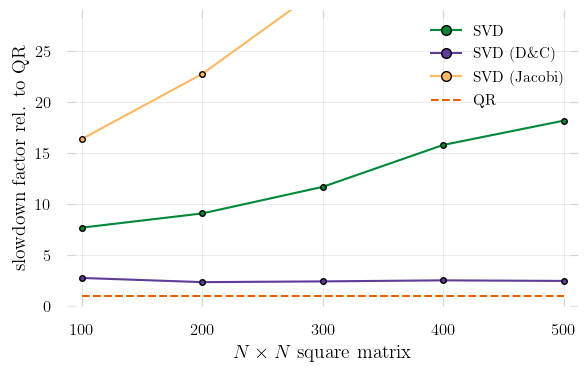

In [42]:
@df df_decomps plot(:N, [:gesvd ./ :qr, :gesdd ./ :qr, :gesvj ./ :qr],
            marker=true,
            color=permutedims(["#008837", "#5E3C99", "#FDB863"]),
            label=permutedims(["SVD", "SVD (D\\&C)", "SVD (Jacobi)"]),
            legend=:topright,
#             legend=(0.6, 0.55),
#             yscale=:log10
            ylims=(0,29)
           )
@df df_decomps plot!(:N, fill(1, length(:N)), color="#E66101", linestyle=:dash, label="QR")
xlabel!(L"$N\times N$ square matrix")
ylabel!("slowdown factor rel. to QR")
savefig("../paper/figures/benchmark_decomps.pdf")

# Performance: Calculate Greens

## Regular inversion

In [55]:
function benchmark_inv_one_plus(; evals=3)
    Ns = Int.(range(100, 500, step=100))
    df = DataFrame(N=Int[], qr=Float64[], gesdd=Float64[], gesvd=Float64[], gesvj=Float64[])

    for N in Ns
        x = rand(ComplexF64, N,N)
        u = udt(x)
        s = svd(x)
        
        t_qr = @belapsed udt_inv_one_plus($u) evals=evals
        t_gesdd = @belapsed svd_inv_one_plus($s, svdalg = $gesdd!) evals=evals
        t_gesvd = @belapsed svd_inv_one_plus($s, svdalg = $gesvd!) evals=evals
        t_gesvj = @belapsed svd_inv_one_plus($s, svdalg = $StableDQMC.gesvj!) evals=evals
        push!(df, [N, t_qr, t_gesdd, t_gesvd, t_gesvj])
    end
    
    return df
end

benchmark_inv_one_plus (generic function with 1 method)

In [56]:
df_greens = benchmark_inv_one_plus()

,N,qr,gesdd,gesvd,gesvj
,Int64,Float64,Float64,Float64,Float64
1,100,0.004828,0.00587553,0.0148525,0.0186636
2,200,0.0175897,0.0229711,0.0824705,0.101569
3,300,0.0391894,0.0565322,0.256174,0.31937
4,400,0.0696482,0.106385,0.621234,0.710891
5,500,0.110309,0.168872,1.21863,1.33005


In [57]:
@save "benchmark_fact_inv_one_plus.bson" df_greens

In [48]:
@load "benchmark_fact_inv_one_plus.bson" df_greens

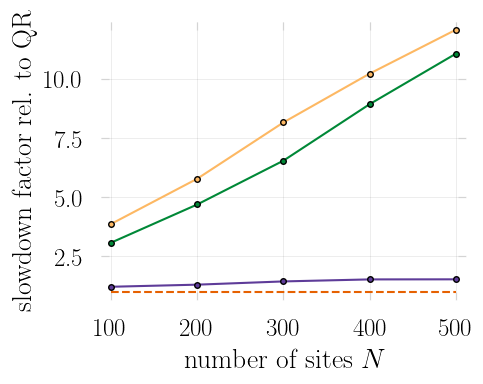

In [49]:
@df df_greens plot(:N, [:gesvd ./ :qr, :gesdd ./ :qr, :gesvj ./ :qr],
            marker=true,
            color=permutedims(["#008837", "#5E3C99", "#FDB863"]), # #E66101 for QR
            label=permutedims(["SVD", "SVD (D\\&C)", "SVD (Jacobi)"]),
            legend=false; two_figures_squarish...,
#             yscale=:log10
#             ylims=(0,50)
           )
@df df_greens plot!(:N, fill(1, length(:N)), color="#E66101", linestyle=:dash, label="QR")
xlabel!(L"number of sites $N$")
ylabel!("slowdown factor rel. to QR")
savefig("../paper/figures/benchmark_fact_inv_one_plus.pdf")

## Loh et al inversion

In [114]:
function benchmark_inv_one_plus_loh(; evals=3)
    Ns = Int.(range(100, 500, step=100))
    df = DataFrame(N=Int[], qr=Float64[], gesdd=Float64[], gesvd=Float64[], gesvj=Float64[])

    for N in Ns
        x = rand(ComplexF64, N,N)
        u = udt(x)
        s = svd(x)
        
        t_qr = @belapsed udt_inv_one_plus_loh($u) evals=evals
        t_gesdd = @belapsed svd_inv_one_plus_loh($s, svdalg = $gesdd!) evals=evals
        t_gesvd = @belapsed svd_inv_one_plus_loh($s, svdalg = $gesvd!) evals=evals
        t_gesvj = @belapsed svd_inv_one_plus_loh($s, svdalg = $StableDQMC.gesvj!) evals=evals
        push!(df, [N, t_qr, t_gesdd, t_gesvd, t_gesvj])
    end
    
    return df
end

benchmark_inv_one_plus_loh (generic function with 1 method)

In [109]:
# horrible "fix" for Julia 1.3 (see https://github.com/JuliaLang/julia/issues/34866), but shouldn't matter for the benchmark
Base.eps(::Type{Complex{Float64}}) = eps(Float64)

In [115]:
df_loh = benchmark_inv_one_plus_loh()

,N,qr,gesdd,gesvd,gesvj
,Int64,Float64,Float64,Float64,Float64
1,100,0.0083081,0.0117527,0.0347288,0.0579956
2,200,0.0295386,0.0440649,0.208961,0.483532
3,300,0.0663493,0.117961,0.63936,1.59792
4,400,0.111888,0.206666,1.51463,3.79708
5,500,0.175929,0.318325,2.91176,7.27374


In [116]:
@save "benchmark_fact_inv_one_plus_loh.bson" df_loh

In [50]:
@load "benchmark_fact_inv_one_plus_loh.bson" df_loh

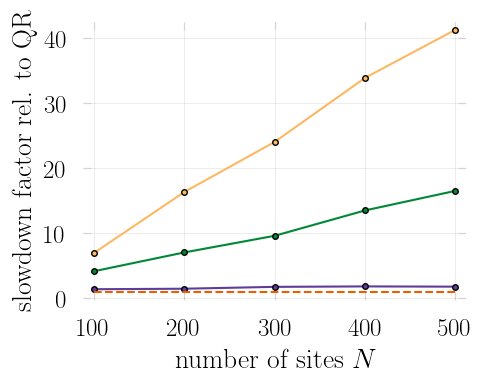

In [51]:
@df df_loh plot(:N, [:gesvd ./ :qr, :gesdd ./ :qr, :gesvj ./ :qr],
            marker=true,
            color=permutedims(["#008837", "#5E3C99", "#FDB863"]), # #E66101 for QR
            label=permutedims(["SVD", "SVD (D\\&C)", "SVD (Jacobi)"]),
            legend=false; two_figures_squarish...,
#             yscale=:log10
#             ylims=(0,50)
           )
@df df_loh plot!(:N, fill(1, length(:N)), color="#E66101", linestyle=:dash, label="QR")
xlabel!(L"number of sites $N$")
ylabel!("slowdown factor rel. to QR")
savefig("../paper/figures/benchmark_fact_inv_one_plus_loh.pdf")

# Accuracy: TDGF

In [65]:
# G(slice, 1) = [B(slice, 1)^-1 + B(beta, slice)]^-1
function accuracy_tdgf(B; loh = false) 
    Bbig = BigFloat.(B)
    
#     betas = range(5, 40, step=5)
    beta = 40
    M = Int(beta * 10)
    slices = 1:10:M

    df = DataFrame(slice=Int[], qr=Float64[], gesdd=Float64[], gesvd=Float64[], gesvj=Float64[])
    
    inv_sum_method = loh ? inv_sum_loh : inv_sum
    
    for s in slices
        local TDGF_genericsvd
        setprecision(1000) do
            TDGF_genericsvd = calc_tdgf_svd(Bbig, s, M-s, inv_sum_method = inv_sum_method, svdalg_chain = genericsvd, svdalg_inv = genericsvd!)
        end
        
        TDGF_qr = calc_tdgf_qr(B, s, M-s, inv_sum_method = inv_sum_method)
        TDGF_gesdd = calc_tdgf_svd(B, s, M-s, inv_sum_method = inv_sum_method, svdalg_chain = gesdd, svdalg_inv = gesdd!)
        TDGF_gesvd = calc_tdgf_svd(B, s, M-s, inv_sum_method = inv_sum_method, svdalg_chain = gesvd, svdalg_inv = gesvd!)
        TDGF_gesvj = calc_tdgf_svd(B, s, M-s, inv_sum_method = inv_sum_method, svdalg_chain = StableDQMC.gesvj, svdalg_inv = StableDQMC.gesvj!)
        
        Δ_qr    = maximum(abs, TDGF_qr - TDGF_genericsvd)
        Δ_gesdd = maximum(abs, TDGF_gesdd - TDGF_genericsvd)
        Δ_gesvd = maximum(abs, TDGF_gesvd - TDGF_genericsvd)
        Δ_gesvj = maximum(abs, TDGF_gesvj - TDGF_genericsvd)
        
        push!(df, [s, Δ_qr, Δ_gesdd, Δ_gesvd, Δ_gesvj])
    end

    return df
end

accuracy_tdgf (generic function with 1 method)

## Regular inversion, $U=0$

In [66]:
@time df_tdgf0 = accuracy_tdgf(B0; loh = false);

150.029976 seconds (680.15 M allocations: 57.395 GiB, 5.33% gc time)


In [67]:
@save "accuracy_tdgf_U0.bson" df_tdgf0

In [18]:
@load "accuracy_tdgf_U0.bson" df_tdgf0

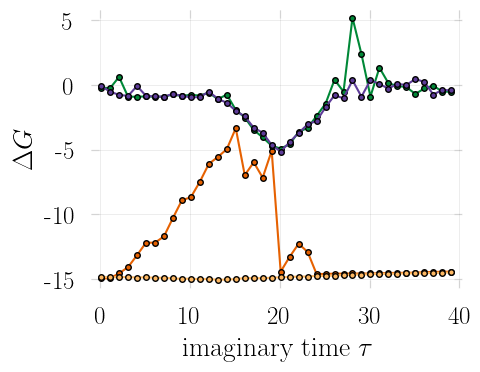

In [19]:
@df df_tdgf0 plot(:slice .* 0.1, (x -> log.(10, x)).([:qr, :gesvd, :gesdd, :gesvj]),
            marker=true,
            color=permutedims(["#E66101", "#008837", "#5E3C99", "#FDB863"]), # #E66101 for QR
            label=permutedims(["QR", "SVD", "SVD (D\\&C)", "SVD (Jacobi)"]),
            legend=false; two_figures_squarish...,
#             xlims=(0,10)
           )
# @df df_tdgf4 plot!(:slice .* 0.1, (x -> log.(10, x)).([:qr, :gesvd, :gesdd, :gesvj]),
#             marker=true,
#             color=permutedims(["#E66101", "#008837", "#5E3C99", "#FDB863"]), # #E66101 for QR
#             alpha=permutedims([.2, .2, .2, .2]), # #E66101 for QR
#             msc="#666666",
#             label=permutedims(["", "", "", ""]),
# #             xlims=(0,10)
#            )
xlabel!(L"imaginary time $\tau$")
ylabel!(L"\Delta G")
savefig("../paper/figures/accuracy_tdgf_U0.pdf")

## Regular inversion, $U=4$

In [70]:
@time df_tdgf4 = accuracy_tdgf(B4; loh = false);

140.077717 seconds (634.70 M allocations: 54.012 GiB, 5.49% gc time)


In [71]:
@save "accuracy_tdgf_U4.bson" df_tdgf4

In [256]:
@load "accuracy_tdgf_U4.bson" df_tdgf4

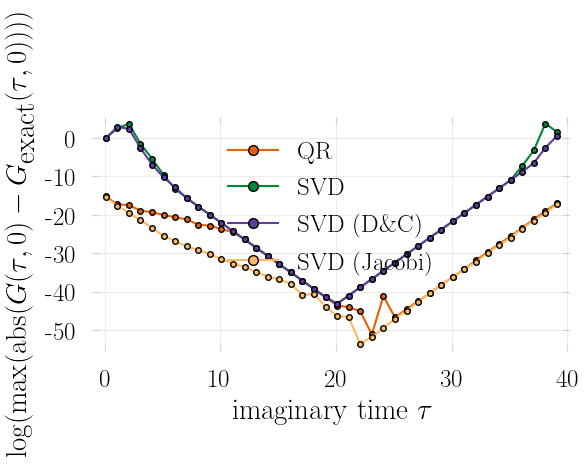

In [257]:
@df df_tdgf4 plot(:slice .* 0.1, (x -> log.(10, x)).([:qr, :gesvd, :gesdd, :gesvj]),
            marker=true,
            color=permutedims(["#E66101", "#008837", "#5E3C99", "#FDB863"]), # #E66101 for QR
            label=permutedims(["QR", "SVD", "SVD (D\\&C)", "SVD (Jacobi)"]); two_figures...,
#             xlims=(0,10)
           )
xlabel!(L"imaginary time $\tau$")
ylabel!(L"\log(\textrm{max}(\textrm{abs}(G(\tau, 0) - G_{\textrm{exact}}(\tau, 0))))")
savefig("../paper/figures/accuracy_tdgf_U4.pdf")

## Loh et al inversion, $U=0$

In [74]:
@time df_tdgf_loh0 = accuracy_tdgf(B0; loh = true);

153.472045 seconds (681.84 M allocations: 57.499 GiB, 6.10% gc time)


In [75]:
@save "accuracy_tdgf_loh_U0.bson" df_tdgf_loh0

In [20]:
@load "accuracy_tdgf_loh_U0.bson" df_tdgf_loh0

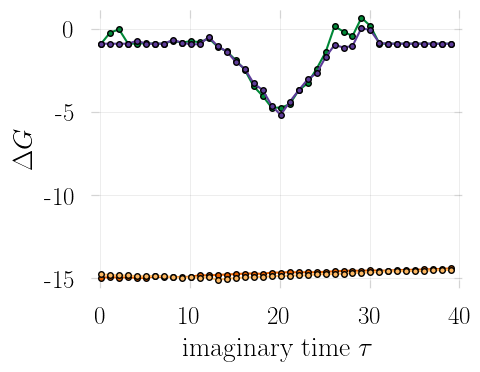

In [21]:
@df df_tdgf_loh0 plot(:slice .* 0.1, (x -> log.(10, x)).([:qr, :gesvd, :gesdd, :gesvj]),
            marker=true,
            color=permutedims(["#E66101", "#008837", "#5E3C99", "#FDB863"]), # #E66101 for QR
            label=permutedims(["QR", "SVD", "SVD (D\\&C)", "SVD (Jacobi)"]),
            legend=false; two_figures_squarish...,
#             xlims=(0,10)
           )
# @df df_tdgf_loh4 plot!(:slice .* 0.1, (x -> log.(10, x)).([:qr, :gesvd, :gesdd, :gesvj]),
#             marker=true,
#             color=permutedims(["#E66101", "#008837", "#5E3C99", "#FDB863"]), # #E66101 for QR
#             alpha=permutedims([.3, .3, .3, .3]), # #E66101 for QR
#             msc="#666666",
#             label=permutedims(["", "", "", ""]),
# #             xlims=(0,10)
#            )
xlabel!(L"imaginary time $\tau$")
ylabel!(L"\Delta G")
savefig("../paper/figures/accuracy_tdgf_loh_U0.pdf")

## Loh et al inversion, $U=4$

In [78]:
@time df_tdgf_loh4 = accuracy_tdgf(B4; loh = true);

142.425446 seconds (637.70 M allocations: 54.256 GiB, 6.84% gc time)


In [79]:
@save "accuracy_tdgf_loh_U4.bson" df_tdgf_loh4

In [260]:
@load "accuracy_tdgf_loh_U4.bson" df_tdgf_loh4

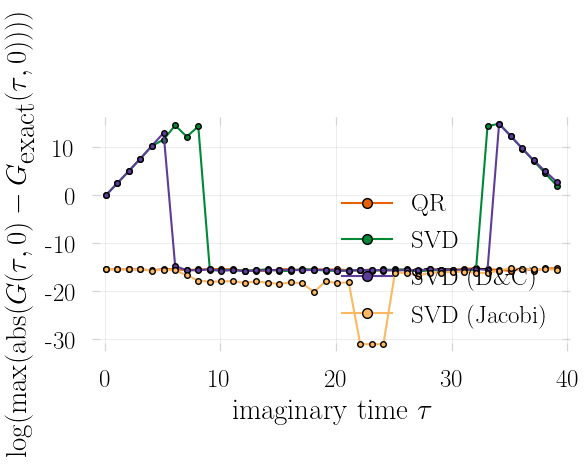

In [261]:
@df df_tdgf_loh4 plot(:slice .* 0.1, (x -> log.(10, x)).([:qr, :gesvd, :gesdd, :gesvj]),
            marker=true,
            color=permutedims(["#E66101", "#008837", "#5E3C99", "#FDB863"]), # #E66101 for QR
            label=permutedims(["QR", "SVD", "SVD (D\\&C)", "SVD (Jacobi)"]); two_figures...,
#             xlims=(0,10)
           )
xlabel!(L"imaginary time $\tau$")
ylabel!(L"\log(\textrm{max}(\textrm{abs}(G(\tau, 0) - G_{\textrm{exact}}(\tau, 0))))")
savefig("../paper/figures/accuracy_tdgf_loh_U4.pdf")

# Performance: Jacobi + Regular vs QR/UDT + Loh

## Equal-times GF

In [82]:
function benchmark_jacobi_vs_qr(; evals=3)
    Ns = Int.(range(100, 500, step=100))
    df = DataFrame(N=Int[], qr=Float64[], gesvj=Float64[])

    for N in Ns
        x = rand(ComplexF64, N,N)
        u = udt(x)
        s = svd(x)
        
        t_qr = @belapsed udt_inv_one_plus_loh($u) evals=evals
        t_gesvj = @belapsed svd_inv_one_plus($s, svdalg = $StableDQMC.gesvj!) evals=evals
        push!(df, [N, t_qr, t_gesvj])
    end
    
    return df
end

benchmark_jacobi_vs_qr (generic function with 1 method)

In [83]:
@time df_vs = benchmark_jacobi_vs_qr();

 77.297934 seconds (2.83 M allocations: 5.230 GiB, 17.88% gc time)


In [84]:
df_vs

,N,qr,gesvj
,Int64,Float64,Float64
1,100,0.00840417,0.0180138
2,200,0.0483159,0.113395
3,300,0.105734,0.348902
4,400,0.176909,0.782798
5,500,0.244487,1.47685


In [85]:
@save "benchmark_jacobi_vs_qr.bson" df_vs

In [428]:
@load "benchmark_jacobi_vs_qr.bson" df_vs

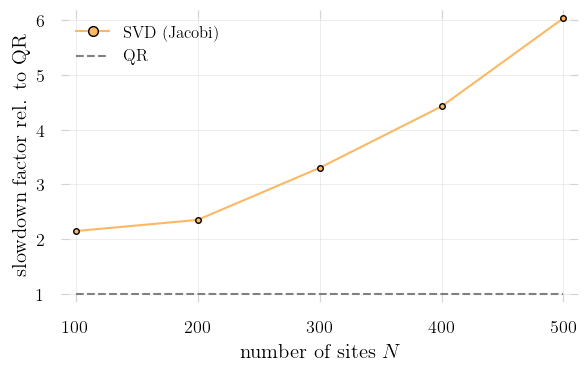

In [87]:
@df df_vs plot(:N, [:gesvj ./ :qr],
            marker=true,
            color=permutedims(["#FDB863"]), # #E66101 for QR, "#008837", "#5E3C99", 
            label=permutedims(["SVD (Jacobi)"]),
#             yscale=:log10
#             ylims=(0,50)
           )
@df df_vs plot!(:N, fill(1, length(:N)), color=:grey, linestyle=:dash, label="QR")
xlabel!(L"number of sites $N$")
ylabel!("slowdown factor rel. to QR")
# savefig("../paper/figures/benchmark_jacobi_vs_qr.pdf")

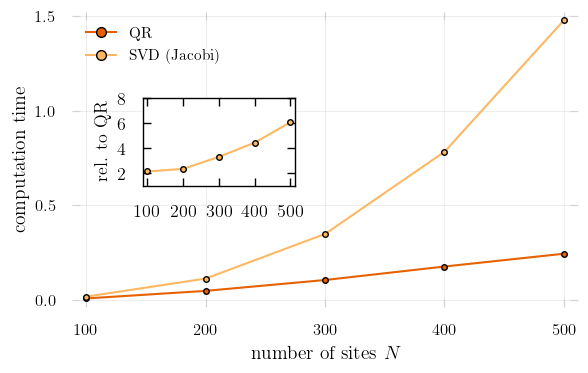

In [433]:
@df df_vs plot(:N, [:qr, :gesvj],
            marker=true,
            color=permutedims(["#E66101", "#FDB863"]),
            label=permutedims(["QR", "SVD (Jacobi)"]),
#             yscale=:log10
#             ylims=(0,50)
           )
xlabel!(L"number of sites $N$")
ylabel!("computation time")

# inset
@df df_vs plot!(:N, [:gesvj ./ :qr],
            inset=(1, bbox(0.14,-0.06,0.3,0.3,:center,:left)),
            marker=true,
            color=permutedims(["#FDB863"]), # #E66101 for QR, "#008837", "#5E3C99", 
            label=permutedims([nothing]),
            subplot=2,
#             xlab=L"number of sites $N$",
            ylab="rel. to QR",
            grid=false,
            frame=:box,
            ylim=(1,8),
            guidefont=font(13),
            xtickfont=font(13), 
            ytickfont=font(13), 
#             legendfont=font(9),
            yticks=[2,4,6,8]
           )
savefig("../paper/figures/benchmark_jacobi_vs_qr.pdf")

## TDGF

In [89]:
# G(slice, 1) = [B(slice, 1)^-1 + B(beta, slice)]^-1
function benchmark_jacobi_vs_qr_tdgf(; evals=3)
#     Ns = ceil.(Int, range(10, 500, length=30) ./ 2) .* 2 # only even N
    Ns = floor.(Int, exp10.(range(log10(5), log10(500), length=40)))
    # Ns = floor.(Int, exp10.(range(log10(5), log10(100), length=20)))
    beta = 40
    M = Int(beta * 10)
    beta_half = Int(M/2) # long imag times

    df = DataFrame(N=Int[], qr=Float64[], gesvj=Float64[])
    
    for N in Ns
        try
            B = rand(ComplexF64, N, N)
            t_qr = @belapsed calc_tdgf_qr($B, $beta_half, $beta_half, inv_sum_method = $inv_sum_loh) evals=evals
            t_gesvj = @belapsed calc_tdgf_svd($B, $beta_half, $beta_half, inv_sum_method = $inv_sum, svdalg_chain = $(StableDQMC.gesvj), svdalg_inv = $(StableDQMC.gesvj!)) evals=evals

            push!(df, [N, t_qr, t_gesvj])
        catch emsg
            @warn "Encountered problem for N=$N."
        end
    end

    return df
end

benchmark_jacobi_vs_qr_tdgf (generic function with 1 method)

In [ ]:
# df_vs_tdgf = benchmark_jacobi_vs_qr_tdgf()

In [ ]:
# @save "benchmark_jacobi_vs_qr_tdgf.bson" df_vs_tdgf

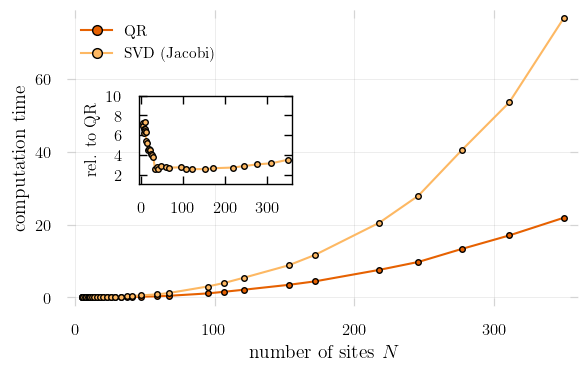

In [435]:
@load "benchmark_jacobi_vs_qr_tdgf.bson" df_vs_tdgf

@df df_vs_tdgf plot(:N, [:qr, :gesvj],
            marker=true,
            color=permutedims(["#E66101", "#FDB863"]),
            label=permutedims(["QR", "SVD (Jacobi)"]),
#             yscale=:log10
#             ylims=(0,50)
           )
xlabel!(L"number of sites $N$")
ylabel!("computation time")

# inset
@df df_vs_tdgf plot!(:N, [:gesvj ./ :qr],
            inset=(1, bbox(0.14,-0.06,0.3,0.3,:center,:left)),
            marker=true,
            color=permutedims(["#FDB863"]), # #E66101 for QR, "#008837", "#5E3C99", 
            label=permutedims([nothing]),
            subplot=2,
#             xlab=L"number of sites $N$",
            ylab="rel. to QR",
#             scale=:log10,
            grid=false,
            frame=:box,
            ylim=(1,10),
            guidefont=font(12),
            xtickfont=font(12), 
            ytickfont=font(12), 
            yticks=[2,4,6,8,10],
           )
savefig("../paper/figures/benchmark_jacobi_vs_qr_tdgf.pdf")